## **DSAI544 - Computer Vision with Machine Learning**

> ## **Assignment 2**


>**Student's Name**: Ahmet Yusuf Öztürk

* The full assignment is worth 15 points in total.
* Write your answers within the correct exercise sections.
* Submit your .ipynb file to Moodle before the due time.
* Files should be named in the following format: DSAI544 Assignment 2 Name Surname
* Your submission must contain your output cells. Those will be necessary for the grading process.

### **Exercise 1: Transformer Based Architecture**⚡
*5 points*

Below is the model definition for a Transformer Network with a Convolutional Patch Embedding layer. Your task is to optimize the network architecture below to improve the model performance. The minimum criteria for success is %75 validation accuracy. Share your training setup including your architecture and any other modifications you have made after the assignment deadline in the Moodle forum. Three students who have the highest accuracy among you will get 2 extra points.

You are free to use other components like MaxPool2d, Dropout, and ReLU from torch.nn library. Please remember the architectural innovations and regularization methods mentioned in the class and try to emulate them here (for instance at the input side of the model you can use known CNN baselines as feature extractor by reimplementing them). You can also change augmentation, learning rate schedulers, optimization methods, positional encoding method and number of attention-head as you like. Don't use predefined models right away but you can reimplement them yourselves.

You will find an implementation from our class for Attention Head and Attention Blocks. Also PS-5&6 might give an insight about swin based structures. **Feel free to improve this implementation and integrate other components**. Keep in mind that CIFAR10 is not a very large dataset so optimizing transformers may prove to be more difficult which is generally not true for larger datasets. Try to restrict the number of parameters that you have in order to get a good generalization performance.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import numpy as np

In [2]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA available: True


In [38]:
transform = transforms.Compose(
    [
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
test_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])


cifar10_full_train = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

cifar10_full_val = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False, transform=test_transform
)

cifar10_test = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform=test_transform)

num_train = 45000
indices = np.random.permutation(50000)

train_idx = indices[:num_train]
val_idx = indices[num_train:]

cifar10_train = Subset(cifar10_full_train, train_idx)
cifar10_val   = Subset(cifar10_full_val, val_idx)

# You can change batch size
batch_size = 32
n = batch_size
dataloader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader_val = DataLoader(cifar10_val, batch_size=batch_size, shuffle=False, num_workers=2)
dataloader_test = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [39]:
class ConvPatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size

        # 32×32 → 16×16
        self.conv1 = nn.Conv2d(
            in_channels,
            embed_dim // 2,
            kernel_size=3,
            stride=2,
            padding=1
        )

        # 16×16 → 8×8
        self.conv2 = nn.Conv2d(
            embed_dim // 2,
            embed_dim,
            kernel_size=3,
            stride=2,
            padding=1
        )

        self.num_patches = (img_size // patch_size) ** 2  # still 64

    def forward(self, x):
        x = self.conv1(x)              # (B, 128, 16, 16)
        x = self.conv2(x)              # (B, 256, 8, 8)
        x = x.flatten(2).transpose(1, 2)
        return x




class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, 3 * embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, E = x.shape

        qkv = self.qkv(x)                    # (B, N, 3E)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)     # (3, B, H, N, D)

        q, k, v = qkv[0], qkv[1], qkv[2]

        attn_scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_probs = attn_scores.softmax(dim=-1)
        attn_probs = self.dropout(attn_probs)

        out = attn_probs @ v                 # (B, H, N, D)
        out = out.transpose(1, 2).reshape(B, N, E)

        return self.out_proj(out)


class MLP(nn.Module):
    def __init__(self, embed_dim, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        hidden_dim = int(embed_dim * mlp_ratio)

        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_ratio, dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=256,
        depth=6,
        num_heads=8,
        mlp_ratio=4.0,
        dropout=0.0
    ):
        super().__init__()

        self.patch_embed = ConvPatchEmbedding(
            img_size, patch_size, in_channels, embed_dim
        )

        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(
                embed_dim, num_heads, mlp_ratio, dropout
            )
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        x = self.patch_embed(x)           # (B, N, E)

        # ---- FIX: drop CLS position ----
        x = x + self.pos_embed[:, 1:, :]  # (1, N, E)

        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)

        # ---- Mean pooling instead of CLS ----
        x = x.mean(dim=1)                 # (B, E)
        return self.head(x)


In [64]:
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
base_lr = 3e-4

model = VisionTransformer(
    img_size=32,
    patch_size=4,
    embed_dim=256,
    depth=6,
    num_heads=8,
    mlp_ratio=4.0,
    num_classes=10
).to("cuda")

optim = torch.optim.AdamW(
    model.parameters(),
    lr=base_lr,
    weight_decay=0.05
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim,
    mode='min',
    factor=0.5,
    patience=4,
    min_lr=1e-6
)


In [46]:
model

VisionTransformer(
  (patch_embed): ConvPatchEmbedding(
    (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-5): 6 x TransformerEncoderBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (out_proj): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-

In [65]:
i = 0
losses = []
steps = []
losses_t = []
val_accuracies = []

In [60]:
import numpy as np

def mixup_data(x, y, alpha=0.3):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [61]:
def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to("cuda"), targets.to("cuda")

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(targets).sum().item()
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [66]:
num_epochs = 100
warmup_epochs = 5
model = model.to('cuda')
patience = 8
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    print("======== epoch:", epoch)
    model.train()

    # ---------- WARMUP ----------
    if epoch < warmup_epochs:
        lr = base_lr * (epoch + 1) / warmup_epochs
        for param_group in optim.param_groups:
            param_group['lr'] = lr

    for batch in dataloader:
        i += 1
        x = batch[0].cuda()
        y = batch[1].cuda()

        # -------- MIXUP --------
        x, y_a, y_b, lam = mixup_data(x, y)

        logits = model(x)

        loss = lam * criterion(logits, y_a) + (1 - lam) * criterion(logits, y_b)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if i % 1000 == 0:
            print(
                f"step {i}, loss={loss.item():.4f}, "
                f"lr={optim.param_groups[0]['lr']:.6f}"
            )

    # ---------- VALIDATION ----------
    val_loss, val_acc = validate(model, dataloader_val, criterion)
    val_accuracies.append(val_acc)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # ---------- SCHEDULER ----------
    if epoch >= warmup_epochs:
        scheduler.step(val_loss)
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        counter = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
        }, 'checkpoint.pth')
    else:
        counter += 1

    if counter >= patience:
        break

======== epoch: 0
step 1000, loss=1.6178, lr=0.000060
Validation Loss: 1.7229, Validation Accuracy: 0.4318
======== epoch: 1
step 2000, loss=1.7995, lr=0.000120
Validation Loss: 1.5560, Validation Accuracy: 0.5108
======== epoch: 2
step 3000, loss=1.5823, lr=0.000180
step 4000, loss=1.6310, lr=0.000180
Validation Loss: 1.4901, Validation Accuracy: 0.5428
======== epoch: 3
step 5000, loss=1.9953, lr=0.000240
Validation Loss: 1.4400, Validation Accuracy: 0.5742
======== epoch: 4
step 6000, loss=1.5000, lr=0.000300
step 7000, loss=2.0058, lr=0.000300
Validation Loss: 1.3877, Validation Accuracy: 0.5974
======== epoch: 5
step 8000, loss=1.4208, lr=0.000300
Validation Loss: 1.3350, Validation Accuracy: 0.6202
======== epoch: 6
step 9000, loss=1.2915, lr=0.000300
Validation Loss: 1.2934, Validation Accuracy: 0.6472
======== epoch: 7
step 10000, loss=1.7317, lr=0.000300
step 11000, loss=1.8867, lr=0.000300
Validation Loss: 1.2972, Validation Accuracy: 0.6362
======== epoch: 8
step 12000, loss

Training has stopped early, due to no improvement in last 8 epochs: 
* Best Validation Loss: 0.9104
* Best Val Accuracy: 0.8444

In [33]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optim.state_dict()
}, 'checkpoint.pth')

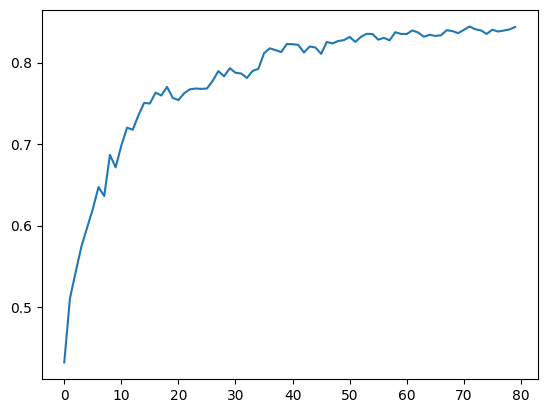

In [71]:
plt.plot(range(len(val_accuracies)), val_accuracies)

In [67]:
# !Do not make major change in this cell

total_correct = 0
total_predictions = 0

# Loop over training dataset
for x_batch, y_batch in dataloader:
    logits = model(x_batch.to("cuda")) # Forward pass on the mini-batch
    loss = F.cross_entropy(logits.cpu(), y_batch) # Compute loss

    # Calculate predictions for the batch
    pred_labels = torch.max(logits, dim=1).indices

    # Update total correct predictions and total predictions
    total_correct += (y_batch == pred_labels.cpu()).sum().item()
    total_predictions += y_batch.size(0)
    break

# Calculate overall accuracy
overall_accuracy = total_correct / total_predictions
print(f"Training Accuracy: {overall_accuracy}")

Training Accuracy: 1.0


In [68]:
# !Do not make major change in this cell

total_correct = 0
total_predictions = 0

# Loop over testing dataset
for x_batch, y_batch in dataloader_test:
    logits = model(x_batch.to("cuda")) # Forward pass on the mini-batch
    loss = F.cross_entropy(logits.cpu(), y_batch) # Compute loss

    # Calculate predictions for the batch
    pred_labels = torch.max(logits, dim=1).indices

    # Update total correct predictions and total predictions
    total_correct += (y_batch == pred_labels.cpu()).sum().item()
    total_predictions += y_batch.size(0)

# Calculate overall accuracy
overall_accuracy = total_correct / total_predictions
print(f"Testting Accuracy: {overall_accuracy}")


Testting Accuracy: 0.8368


## **Exercise 2: Detecting and Segmenting Raccoons 🦝**
*10 points*

#### **Step 1**

In this first step, you will set up the environment. You need to import the necessary libraries for this project, such as autodistill-grounded-sam, supervision, ultralytics, roboflow, and PyTorch with torchvision. Make sure to install them using pip. This ensures that we have all the tools we need to work with GroundedSAM and YOLO for image analysis and model training. The code is already given. Run & proceed to the next step.

**Working Package Versions**

If the code doesn't work in your environment, try installing the packages with respect to these versions, then try again it will probably work.


*   `autodistill: 0.1.29`
*   `autodistill_grounded_sam: 0.1.2`
*   `roboflow: 1.2.11`
*   `ultralytics: 8.3.235`





In [3]:
%pip install autodistill-grounded-sam
%pip install supervision
%pip install ultralytics
%pip install roboflow
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


c:\Users\baldi\AppData\Local\Programs\Python\Python311\python.exe: No module named pip


Note: you may need to restart the kernel to use updated packages.


c:\Users\baldi\AppData\Local\Programs\Python\Python311\python.exe: No module named pip


Note: you may need to restart the kernel to use updated packages.


c:\Users\baldi\AppData\Local\Programs\Python\Python311\python.exe: No module named pip
c:\Users\baldi\AppData\Local\Programs\Python\Python311\python.exe: No module named pip


Note: you may need to restart the kernel to use updated packages.


c:\Users\baldi\AppData\Local\Programs\Python\Python311\python.exe: No module named pip

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


c:\Users\baldi\AppData\Local\Programs\Python\Python311\python.exe: No module named pip


#### **Step 2**

Now, import the specific components that you will use from the installed libraries. You will be utilizing GroundedSAM for object detection and segmentation, CaptionOntology for defining object categories, plotting tools from autodistill, and OpenCV for basic image operations. Importing these modules makes them readily available for use in your code. The code is already given. Run & proceed to the next step.

In [3]:
from autodistill_grounded_sam import GroundedSAM
from autodistill.detection import CaptionOntology
from autodistill.utils import plot
import cv2

In [4]:
from autodistill.detection.detection_base_model import roboflow
import autodistill
import autodistill_grounded_sam
import ultralytics

print("autodistill:", autodistill.__version__)
print("autodistill_grounded_sam:", autodistill_grounded_sam.__version__)
print("roboflow:", roboflow.__version__)
print("ultralytics:", ultralytics.__version__)

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\baldi\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
autodistill: 0.1.29
autodistill_grounded_sam: 0.1.2
roboflow: 1.2.11
ultralytics: 8.3.241


#### **Step 3**

Before you can start processing images, you need to prepare the dataset. Upload the dataset to Google Colab (if you are using Colab). This code block will focus on extracting image data from the zip file named 'images.zip'. First, define the path to the zip file and the directory where images should be extracted. Then, use the zip file library to extract the contents of the zip file into the specified directory. Unzip your files.

**You can download the dataset from this drive** [**link**](https://drive.google.com/file/d/1a6ebsACZXugcI6oWr6wo4GD2vcGbKB19/view?usp=sharing)

In [77]:
import zipfile
import os

# I loaded the zip file to my Colab workspace manually
zip_file_path = r'C:\Users\baldi\Desktop\Dsai assignmen 2\images.zip'
output_dir = r'C:\Users\baldi\Desktop\Dsai assignmen 2\images'

os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Files extracted")



Files extracted


#### **Step 4**

Here, initialize the GroundedSAM model (name it as base_model) using a specific ontology. The ontology, defined using CaptionOntology, specifies the categories of objects you are interested in. In this case, you are only focusing on detecting and segmenting 'raccoons.' Creating this base model sets the foundation for object recognition in your images. You will use this model to label your dataset.
Your code will look like this, fill the stars:
```
base_model = GroundedSAM(
    ontology=CaptionOntology(
        {
            "*******": "*******"
        }
    )
)
```





In [5]:
base_model = GroundedSAM(
    ontology=CaptionOntology(
        {
            "raccoons": "raccoons"
        }
    )
)

trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)


final text_encoder_type: bert-base-uncased


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl

In [6]:
base_model

GroundedSAM(ontology=CaptionOntology(promptMap=[('raccoons', 'raccoons')]), grounding_dino_model=<groundingdino.util.inference.Model object at 0x000001F7B07FDC10>, sam_predictor=<segment_anything.predictor.SamPredictor object at 0x000001F7B08524D0>, box_threshold=0.35, text_threshold=0.25)

#### **Step 5**

Now, test the GroundedSAM model on a single image. Choose a random image from the dataset by hand, load it, perform inference using the .predict() method of `base_model`, and then visualize the results.

Use the plot function which will help you to see the detected objects, their bounding boxes, and segmentation masks overlaid on the original image. This gives you a visual confirmation of the model's performance.

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


detections: Detections(xyxy=array([[     40.422,      80.611,      342.16,      380.77]], dtype=float32), mask=array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]], shape=(1, 416, 416)), confidence=array([    0.61121], dtype=float32), class_id=array([0]), tracker_id=None, data={}, metadata={})


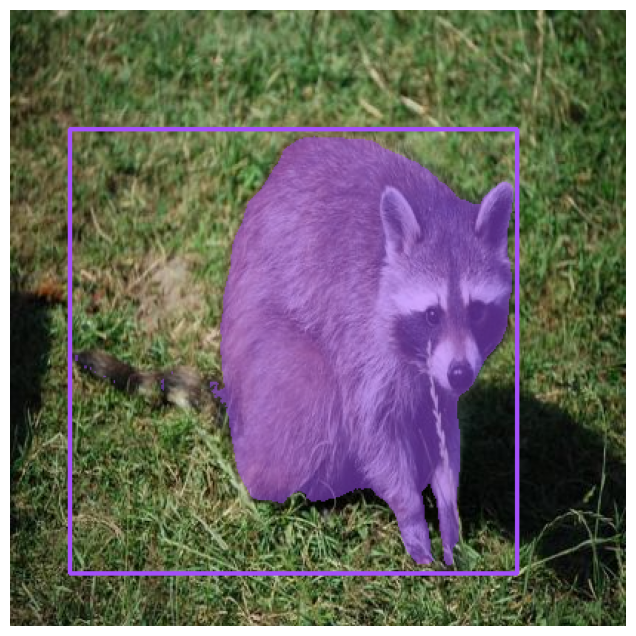

In [8]:
import supervision as sv

image_path = r'C:\Users\baldi\Desktop\Dsai assignmen 2\images\images\rac (1).jpg'


# annotators for masks and boxes
mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

confirmation_image = cv2.imread(image_path)

classes = base_model.ontology.classes()

detections = base_model.predict(confirmation_image)
print("detections:",detections)

# Create labels for the detected objects
# labels = [
#     f"{classes[class_id]} {confidence:.2f}"
#     for _, confidence, class_id, _ in detections
# ]
# Create labels for the detected objects
labels = [
    f"{classes[class_id]} {conf:.2f}"
    for class_id, conf in zip(detections.class_id, detections.confidence)
]


# annotate the image
annotated_frame = mask_annotator.annotate(
    scene=confirmation_image.copy(),
    detections=detections
)

# annotate the image
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections
    # labels=labels
)

sv.plot_image(annotated_frame, size=(8, 8))


#### **Step 6**

To train a more specific model using YOLO, we need labeled data. Use the GroundedSAM model (named as `base_model` in previous steps) to label images. It will use the predefined ontology to identify and label 'raccoons' in the dataset. The labeled data will be crucial for fine-tuning the YOLO model in the next steps. Use the .label() method of "base_model" you defined in step 4 with the correct path and extension parameters.

In [12]:
images_path = r'C:\Users\baldi\Desktop\Dsai assignmen 2\images\images'
labels_path = r'C:\Users\baldi\Desktop\Dsai assignmen 2\labeled_data'
dataset = base_model.label(input_folder=images_path, output_folder=labels_path, extension="jpg") # base_model = grounded_sam
print(f"Labeled data has been saved to: {labels_path}")

Labeling C:\Users\baldi\Desktop\Dsai assignmen 2\images\images\rac (1).jpg:   0%|          | 0/196 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
Labeling C:\Users\baldi\Desktop\Dsai assignmen 2\images\images\rac (99).jpg: 100%|██████████| 196/196 [14:28<00:00,  4.43s/it] 


Labeled dataset created - ready for distillation.
Labeled data has been saved to: C:\Users\baldi\Desktop\Dsai assignmen 2\labeled_data


#### **Step 7**


Now over colab's UI, prepare a UI where you can view images with their labels. If the labeling is not successful, you will remove the image and its corresponding .txt labeling file. Iterate over the dataset and remove the unsuccessfully labeled ones. An example solution code for such UI is given below. Please note that it is natural to have a very different code as your solution as many things can vary (naming, design, paths, etc...).

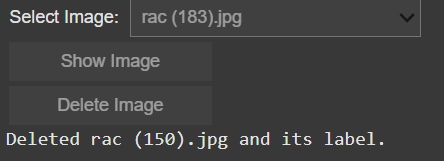


```
import os
import ipywidgets as widgets
from IPython.display import display, clear_output


# paths to dataset splits
base_dir = "/content/labeled_data"
splits = ["train", "valid"]


# Helper function to plot an image with detections
def plot_image_with_detections(image_path, base_model):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    # help(base_model.predict)
    # setting threshold to 0.1
    base_model.box_threshold = 0.1
    base_model.text_threshold = 0.1
    print("box thresh:",base_model.box_threshold)
    print("text thresh:",base_model.text_threshold)
    detections = base_model.predict(image_path)

    mask_annotator = sv.MaskAnnotator()
    box_annotator = sv.BoxAnnotator()

    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)

    # draw class labels manually, updated supervision does not do it
    for box, class_id, confidence in zip(detections.xyxy, detections.class_id, detections.confidence):
        # bbox coordinates
        x1, y1, x2, y2 = map(int, box)

        # labels
        label = f"{classes[class_id]} {confidence:.2f}"

        cv2.rectangle(annotated_image, (x1, y1 - 20), (x1 + len(label) * 10, y1), (0, 0, 0), -1)
        cv2.putText(annotated_image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)


    sv.plot_image(annotated_image, size=(8, 8))


# get the list of images in the selected split
def get_image_list(split):
    images_dir = os.path.join(base_dir, split, "images")
    return [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]


def show_image_selection_ui(base_model):
    # dropdown to select the dataset split
    split_selector = widgets.Dropdown(
        options=splits,
        description='Select Split:',
        disabled=False
    )

    # dropdown to select an image
    image_selector = widgets.Dropdown(
        options=[],
        description='Select Image:',
        disabled=False
    )

    # buttons
    show_button = widgets.Button(description="Show Image", button_style='success')
    delete_button = widgets.Button(description="Delete Image", button_style='danger')
    output = widgets.Output()


    def update_image_list(change):
        split = split_selector.value
        image_list = get_image_list(split)
        image_selector.options = image_list


    def show_image(change):
        with output:
            clear_output(wait=True)
            split = split_selector.value
            image_path = os.path.join(base_dir, split, "images", image_selector.value)
            plot_image_with_detections(image_path, base_model)


    def delete_image(change):
        with output:
            clear_output(wait=True)
            split = split_selector.value
            image_path = os.path.join(base_dir, split, "images", image_selector.value)
            label_path = os.path.join(base_dir, split, "labels", os.path.splitext(image_selector.value)[0] + ".txt")

            if os.path.exists(image_path):
                os.remove(image_path)
            if os.path.exists(label_path):
                os.remove(label_path)

            # update the dropdown options after deletion
            image_selector.options = get_image_list(split)
            print(f"Deleted {os.path.basename(image_path)} and its label.")


    split_selector.observe(update_image_list, names='value')
    show_button.on_click(show_image)
    delete_button.on_click(delete_image)

    # display UI
    display(widgets.VBox([split_selector, image_selector, show_button, delete_button, output]))
    update_image_list(None)

show_image_selection_ui(base_model)

```



In [14]:
import os
import ipywidgets as widgets
from IPython.display import display, clear_output


# paths to dataset splits
base_dir = labels_path
splits = ["train", "valid"]


# Helper function to plot an image with detections
def plot_image_with_detections(image_path, base_model):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    # help(base_model.predict)
    # setting threshold to 0.1
    base_model.box_threshold = 0.1
    base_model.text_threshold = 0.1
    print("box thresh:",base_model.box_threshold)
    print("text thresh:",base_model.text_threshold)
    detections = base_model.predict(image_path)

    mask_annotator = sv.MaskAnnotator()
    box_annotator = sv.BoxAnnotator()

    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)

    # draw class labels manually, updated supervision does not do it
    for box, class_id, confidence in zip(detections.xyxy, detections.class_id, detections.confidence):
        # bbox coordinates
        x1, y1, x2, y2 = map(int, box)

        # labels
        label = f"{classes[class_id]} {confidence:.2f}"

        cv2.rectangle(annotated_image, (x1, y1 - 20), (x1 + len(label) * 10, y1), (0, 0, 0), -1)
        cv2.putText(annotated_image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)


    sv.plot_image(annotated_image, size=(8, 8))


# get the list of images in the selected split
def get_image_list(split):
    images_dir = os.path.join(base_dir, split, "images")
    return [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]


def show_image_selection_ui(base_model):
    # dropdown to select the dataset split
    split_selector = widgets.Dropdown(
        options=splits,
        description='Select Split:',
        disabled=False
    )

    # dropdown to select an image
    image_selector = widgets.Dropdown(
        options=[],
        description='Select Image:',
        disabled=False
    )

    # buttons
    show_button = widgets.Button(description="Show Image", button_style='success')
    delete_button = widgets.Button(description="Delete Image", button_style='danger')
    output = widgets.Output()


    def update_image_list(change):
        split = split_selector.value
        image_list = get_image_list(split)
        image_selector.options = image_list


    def show_image(change):
        with output:
            clear_output(wait=True)
            split = split_selector.value
            image_path = os.path.join(base_dir, split, "images", image_selector.value)
            plot_image_with_detections(image_path, base_model)


    def delete_image(change):
        with output:
            clear_output(wait=True)
            split = split_selector.value
            image_path = os.path.join(base_dir, split, "images", image_selector.value)
            label_path = os.path.join(base_dir, split, "labels", os.path.splitext(image_selector.value)[0] + ".txt")

            if os.path.exists(image_path):
                os.remove(image_path)
            if os.path.exists(label_path):
                os.remove(label_path)

            # update the dropdown options after deletion
            image_selector.options = get_image_list(split)
            print(f"Deleted {os.path.basename(image_path)} and its label.")


    split_selector.observe(update_image_list, names='value')
    show_button.on_click(show_image)
    delete_button.on_click(delete_image)

    # display UI
    display(widgets.VBox([split_selector, image_selector, show_button, delete_button, output]))
    update_image_list(None)

show_image_selection_ui(base_model)

#### **Step 8**

Now leverage the power of YOLO for more robust object detection. Start by importing the YOLO from the ultralytics library. Then, load a pre-trained YOLO11n model. Name it `model_detect`.

Use:
`model_detect = YOLO("yolo11n.pt")`

Next, use the .train() method to fine-tune this model on the labeled data generated earlier. This process will involve feeding the model our labeled images and allowing it to learn and adjust its parameters for better performance. Pass the path to the .yaml file (ex.  `data="/content/images_labeled/data.yaml"`) inside the train function. Remember to specify training parameters. Set  `imgsz=416` and `name="yolo_detection"`.




In [23]:

import gc

gc.collect()
torch.cuda.empty_cache()


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001F7AB5BC540>
Traceback (most recent call last):
  File "c:\Users\baldi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\baldi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


In [25]:
from ultralytics import YOLO
import shutil

data_yaml_path = r"C:\Users\baldi\Desktop\Dsai assignmen 2\labeled_data\data.yaml"

model = YOLO("yolov8s.pt")

model.train(
    data=data_yaml_path,
    imgsz=416,
    epochs=50,
    batch=4,
    optimizer="AdamW",
    lr0=0.002,
    patience=15,
    mosaic=0.5,
    close_mosaic=10,
    augment=True,
    workers=4,
    device=0
)

Ultralytics 8.3.241  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\baldi\Desktop\Dsai assignmen 2\labeled_data\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, pat

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F8C36F9250>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

#### **Step 9**

Now, let's see the YOLO model in action on a new image! Load a test image, choose it by hand from the validation dataset and use the trained model to make prediction on it. The result will contain information about the detected object, including their bounding boxes and confidence scores.

Use the show method to display the results visually – this will overlay the detected objects on the test image, giving you a clear view of the model's detection capabilities.


image 1/1 C:\Users\baldi\Desktop\Dsai assignmen 2\labeled_data\valid\images\rac (37).jpg: 416x416 1 raccoons, 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)
Results saved to C:\Users\baldi\Desktop\Dsai assignmen 2\runs\detect\predict


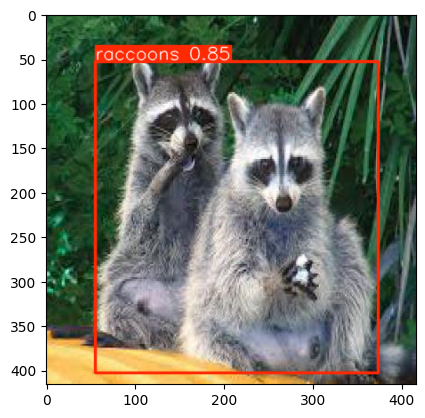

In [34]:
import matplotlib.pyplot as plt

# you can change your test image
test_image_path = r"C:\Users\baldi\Desktop\Dsai assignmen 2\labeled_data\valid\images\rac (37).jpg"

# write your code here
results = model.predict(source=test_image_path, conf=0.25, save=True)
for result in results:
    plt.imshow(result.plot())

#### **Step 10**

For the detection model, output the "results.png" generated in /runs folder.

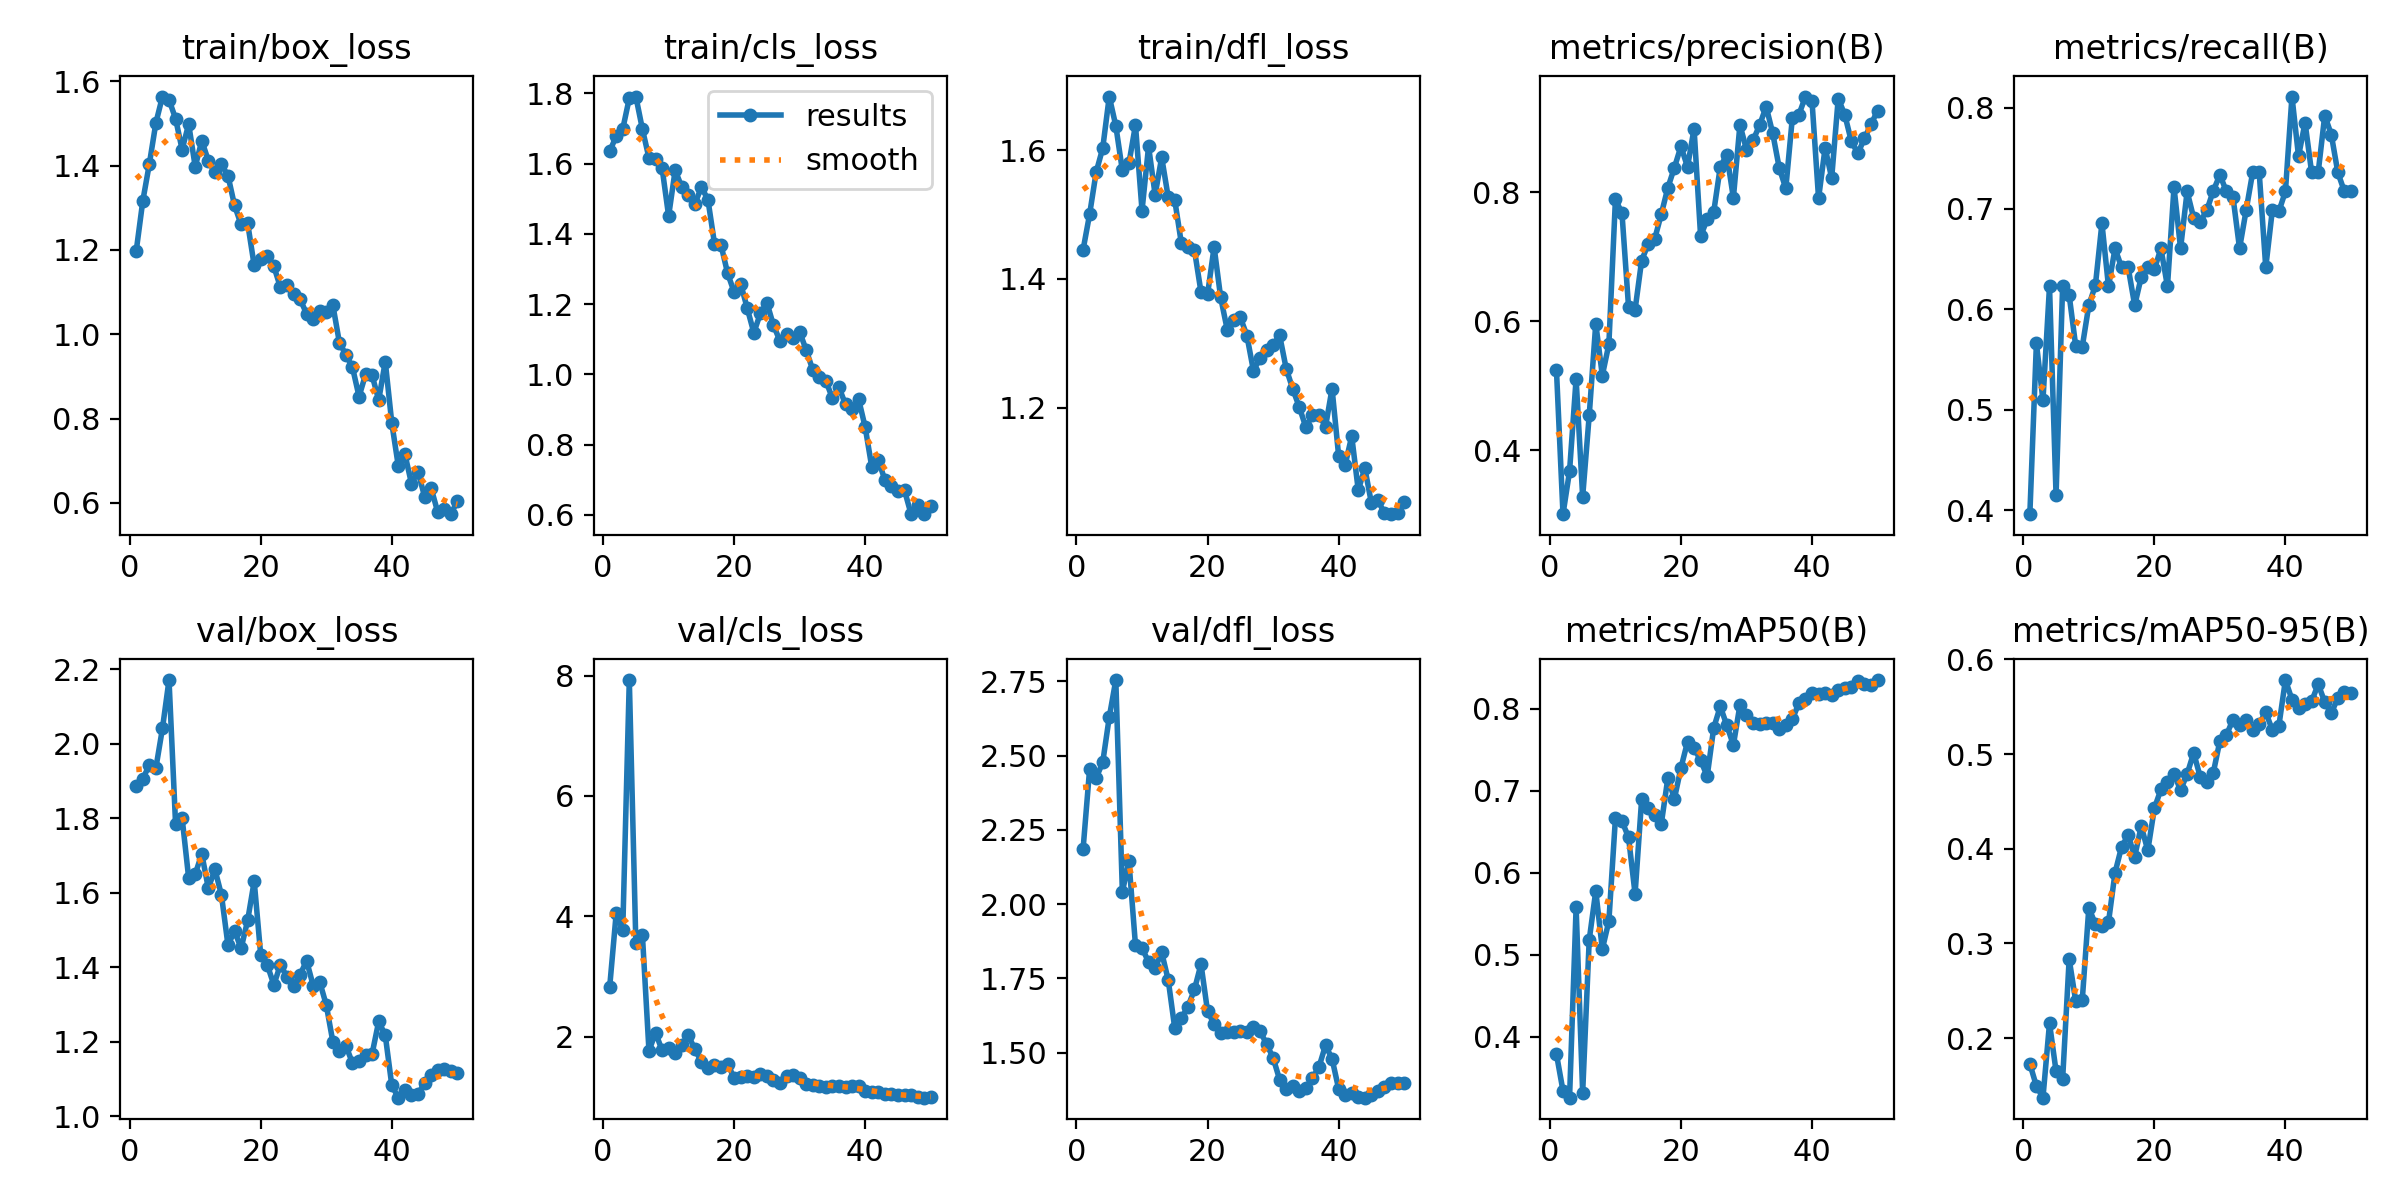

In [35]:
from IPython.display import Image, display

results_path = r"C:\Users\baldi\Desktop\Dsai assignmen 2\runs\detect\train\results.png"
display(Image(filename=results_path))

#### **Step 11**

Finally, to make your trained YOLO model usable in other environments or applications, you need to export it to a suitable format. The export method allows you to save the model in various formats like ONNX, Torchscript, or CoreML, depending on your needs.

In this exercise you will export your model in "onnx" format for future use. This ensures that your trained model is portable and can be integrated into different systems.

In [37]:
model.export(format="onnx")

Ultralytics 8.3.241  Python-3.11.9 torch-2.5.1+cu121 CPU (Intel Core i7-10750H 2.60GHz)

PyTorch: starting from 'C:\Users\baldi\Desktop\Dsai assignmen 2\runs\detect\train\weights\best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 5, 3549) (21.4 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
WARNING Retry 1/2 failed: Command 'pip install --no-cache-dir "onnxslim>=0.1.71" "onnxruntime-gpu" ' returned non-zero exit status 1.
WARNING Retry 2/2 failed: Command 'pip install --no-cache-dir "onnxslim>=0.1.71" "onnxruntime-gpu" ' returned non-zero exit status 1.
WARNING requirements:  Command 'pip install --no-cache-dir "onnxslim>=0.1.71" "onnxruntime-gpu" ' returned non-zero exit status 1.

ONNX: starting export with onnx 1.20.0 opset 19...
WARNING ONNX: simplifier failure: No module named 'onnxslim'
ONNX: export success  3.7s, saved as 'C:\Users\baldi\Desktop\Dsai assignmen 2\runs\detect\train\weights

'C:\\Users\\baldi\\Desktop\\Dsai assignmen 2\\runs\\detect\\train\\weights\\best.onnx'

#### **Step 12**

Now do the last steps again with the segmentation model.
Start with the code below. Again, set `imgsz=416` and `name="yolo_segmentation"`.

Use:
`model_segment = YOLO("yolo11n-seg.pt")`

In [38]:
model_segment = YOLO("yolo11n-seg.pt")

model_segment.train(
    data=data_yaml_path,
    imgsz=416,
    epochs=50,
    batch=4,
    optimizer="AdamW",
    lr0=0.002,
    patience=15,
    mosaic=0.5,
    close_mosaic=10,
    augment=True,
    workers=4,
    device=0
)

Ultralytics 8.3.241  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\baldi\Desktop\Dsai assignmen 2\labeled_data\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True,

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F8CF753D50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0410

#### **Step 13**

Again, use the show method to display the results visually for the same image you choose in step 9 – this will overlay the detected objects with their segmentations on the test image, giving you a clear view of the model's segmentation capabilities.


image 1/1 C:\Users\baldi\Desktop\Dsai assignmen 2\labeled_data\valid\images\rac (37).jpg: 416x416 1 raccoons, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 14.4ms postprocess per image at shape (1, 3, 416, 416)
Results saved to C:\Users\baldi\Desktop\Dsai assignmen 2\runs\segment\predict


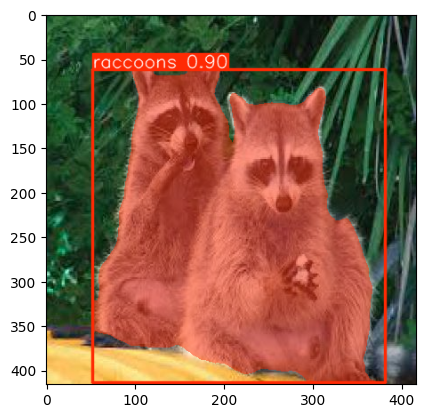

In [39]:
import matplotlib.pyplot as plt

# you can change your test image
test_image_path = r"C:\Users\baldi\Desktop\Dsai assignmen 2\labeled_data\valid\images\rac (37).jpg"

# write your code here
results = model_segment.predict(source=test_image_path, conf=0.25, save=True)
for result in results:
    plt.imshow(result.plot())


image 1/1 C:\Users\baldi\Desktop\Dsai assignmen 2\dummy_ood.jpg: 320x416 2 raccoonss, 13.2ms
Speed: 1.8ms preprocess, 13.2ms inference, 8.6ms postprocess per image at shape (1, 3, 320, 416)
Results saved to C:\Users\baldi\Desktop\Dsai assignmen 2\runs\segment\predict


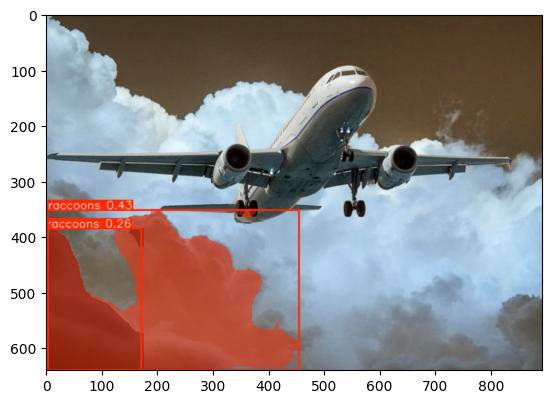

In [41]:
ood_test_image = r"C:\Users\baldi\Desktop\Dsai assignmen 2\dummy_ood.jpg"
# test without size adjusting
results = model_segment.predict(source=ood_test_image, conf=0.25, save=True)
for result in results:
    plt.imshow(result.plot())

#### **Step 14**

For the segmentation model, output the "results.png" generated in the /runs folder.

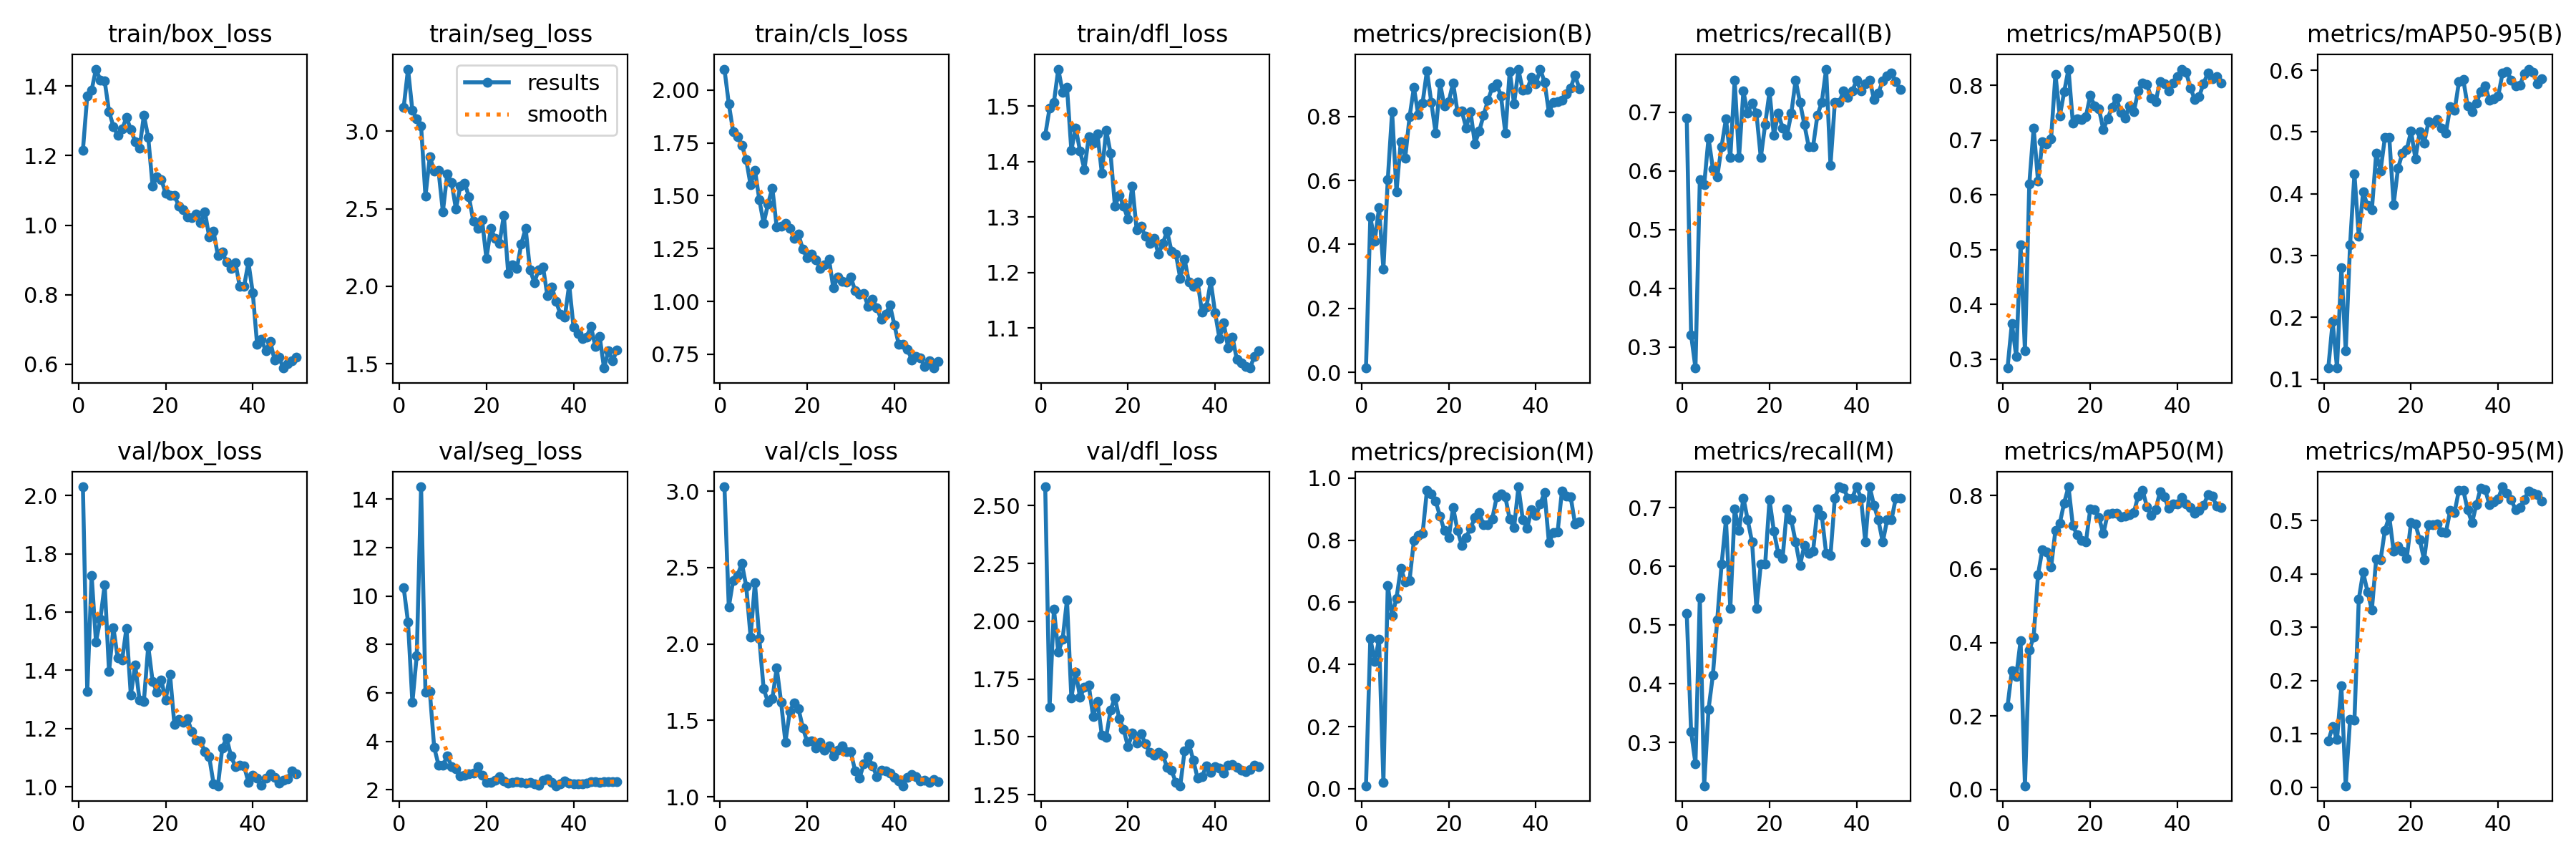

In [42]:
results_path = r"C:\Users\baldi\Desktop\Dsai assignmen 2\runs\segment\train\results.png"
display(Image(filename=results_path))

#### **Step 15**

Export your segmentation model in "onnx" format.

In [43]:
model_segment.export(format="onnx")

Ultralytics 8.3.241  Python-3.11.9 torch-2.5.1+cu121 CPU (Intel Core i7-10750H 2.60GHz)

PyTorch: starting from 'C:\Users\baldi\Desktop\Dsai assignmen 2\runs\segment\train\weights\best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) ((1, 37, 3549), (1, 32, 104, 104)) (5.7 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
WARNING Retry 1/2 failed: Command 'pip install --no-cache-dir "onnxslim>=0.1.71" "onnxruntime-gpu" ' returned non-zero exit status 1.
WARNING Retry 2/2 failed: Command 'pip install --no-cache-dir "onnxslim>=0.1.71" "onnxruntime-gpu" ' returned non-zero exit status 1.
WARNING requirements:  Command 'pip install --no-cache-dir "onnxslim>=0.1.71" "onnxruntime-gpu" ' returned non-zero exit status 1.

ONNX: starting export with onnx 1.20.0 opset 19...
WARNING ONNX: simplifier failure: No module named 'onnxslim'
ONNX: export success  3.3s, saved as 'C:\Users\baldi\Desktop\Dsai assignmen 2\run

'C:\\Users\\baldi\\Desktop\\Dsai assignmen 2\\runs\\segment\\train\\weights\\best.onnx'

Congratulations! 🎉

Now you have successfully fine-tuned your detection and segmentation models. They are ready to use.